##### useful tricks
https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63984


In [1]:
%matplotlib inline
import os, time, shutil
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#from coslib import plot_polygon_seg_test_NG, plot_polygon_seg_test_OK
#from coslib import load_images_masks_json
#from coslib import get_mask_seg_polygon,  get_mask_seg_polygon_OK
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import datasets, manifold
#from scipy.ndimage import rotate
from IPython.display import Image
import random
import tensorflow as tf
random.seed(42)
np.random.seed(42)

In [2]:
pwd = os.getcwd()
print(pwd)

/home/itri/chandni/autoencoder


In [3]:
#df_ref = pd.read_csv('/home/ny/ITRI/itri_fetal_signal/records2_1028.csv', header=0)

In [3]:
label1 = np.load('20278_label1.npy')
df_label = pd.DataFrame(label1)
df_label.columns = ['angular_speed', 'channel', 'source']
df_label.head()

,angular_speed,channel,source
0,250.0,1.0,1.0
1,250.0,1.0,1.0
2,250.0,1.0,1.0
3,250.0,1.0,1.0
4,250.0,1.0,1.0


In [4]:
data = np.load('20278_4097.npy')
print(data.shape)

data_log = np.log(data)

data_down_log1 = data_log[:,::2]
data_down_log2 = data_log[:,1::2]
data_down_log = (data_down_log1[:,:-1]+data_down_log2)/2.

data_norm = data_down_log/10.

print(data_down_log1.shape, data_down_log2.shape, data_norm.shape)

(20278, 4097)
(20278, 2049) (20278, 2048) (20278, 2048)


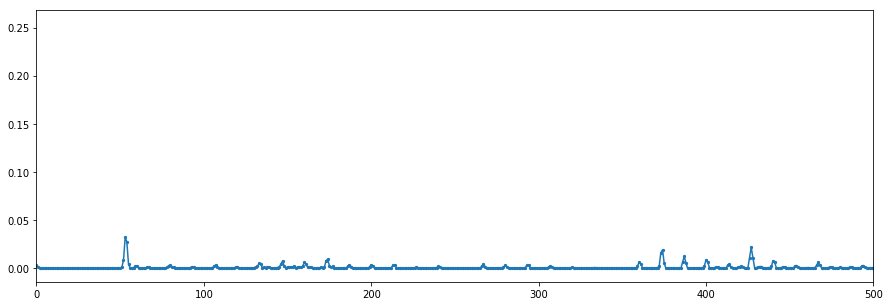

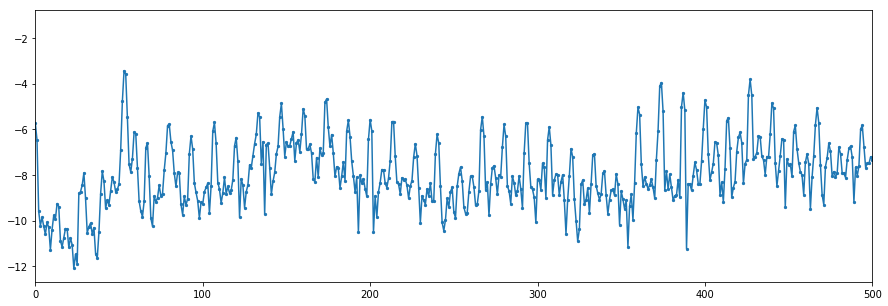

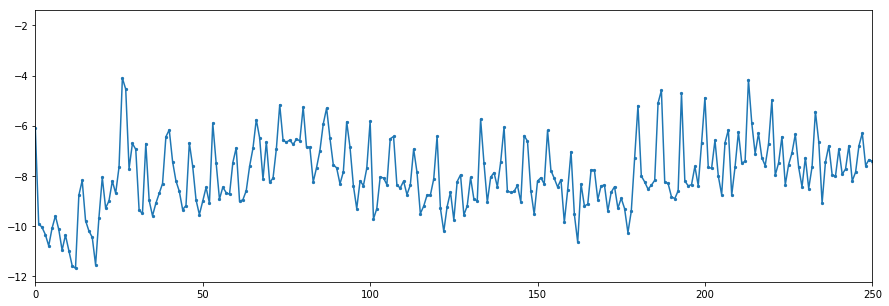

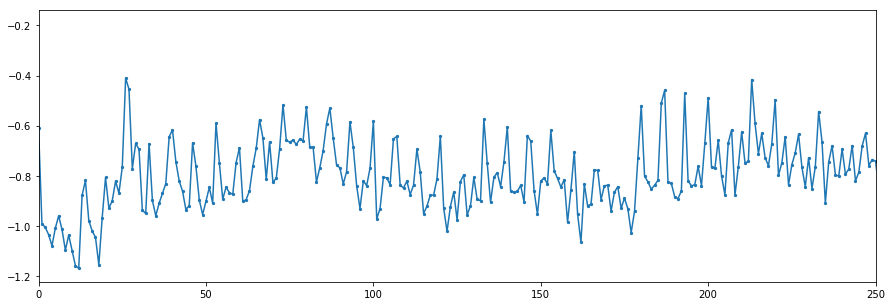

In [5]:
for j in range(10000,10001):
    plt.rcParams['figure.figsize'] = [15.0, 5.0]
    plt.rcParams['font.size'] = 10
    plt.xlim(0, 500)
    plt.plot(range(4097), data[j,:])
    plt.scatter(range(4097), data[j,:], s=5)
    plt.show()
    
    plt.xlim(0, 500)
    plt.plot(range(4097), data_log[j,:])
    plt.scatter(range(4097), data_log[j,:], s=5)
    plt.show()
    
    plt.xlim(0, 250)
    plt.plot(range(2048), data_down_log[j,:])
    plt.scatter(range(2048), data_down_log[j,:], s=5)
    plt.show()
    
    plt.xlim(0, 250)
    plt.plot(range(2048), data_norm[j,:])
    plt.scatter(range(2048), data_norm[j,:], s=5)
    plt.show()

                  0
count  4.152934e+07
mean  -7.230468e-01
std    1.600192e-01
min   -1.457863e+00
25%   -8.419211e-01
50%   -7.409230e-01
75%   -6.031356e-01
max    6.658639e-02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c6d096278>]],
      dtype=object)

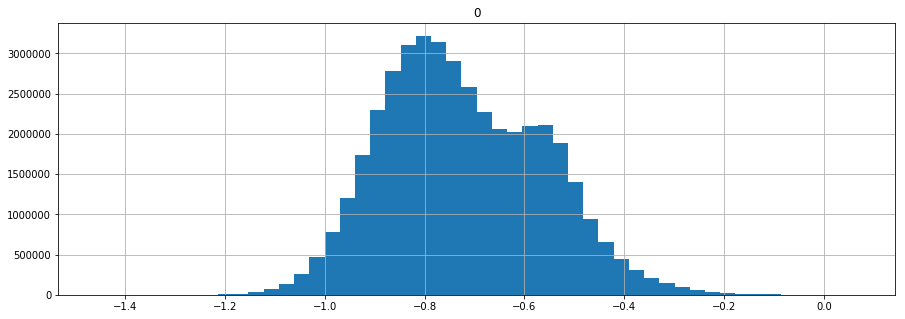

In [6]:
seri_ = pd.DataFrame(data_norm.reshape(-1))
print(  seri_.describe()   )
seri_.hist(bins=50)

In [7]:
idx_ = list(range( len(data_norm)  ))
np.random.shuffle(  idx_  )
data_norm = data_norm[idx_]
label1 = label1[idx_]

print(len(data_norm))

20278


In [8]:
nb_train = int(0.85* len(data_norm))
print(nb_train)
X_train = -data_norm[:nb_train, :]
X_test = -data_norm[nb_train:, :]

X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))
#X_train = X_train.reshape(  (X_train.shape[0], int(X_train.shape[1]/2), 2)   )
#X_test = X_test.reshape(   (X_test.shape[0], int(X_test.shape[1]/2), 2)   )
print(X_train.shape, X_test.shape)


y1_train = label1[:nb_train, :]
y1_test = label1[nb_train:, :]

17236
(17236, 2048, 1) (3042, 2048, 1)


In [63]:
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D,Lambda, Conv2DTranspose, concatenate, BatchNormalization
from keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time
from keras.layers import Dropout

from keras import layers
from keras import models
import keras.backend as K

In [64]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same'):
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = layers.Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [65]:
img_rows = X_train.shape[1]

In [66]:
def autoencoder_1(nb_flt = 8, drop_rate = 0.1):
    kernel_size = 7
    inputs = Input((img_rows,1))
    #inputs_norm = Lambda(lambda x: x/127.5 )
    #inputs_norm = Lambda(lambda x: x/1. )        
    #conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs_norm(inputs))
    conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2, )(conv1)
    
    conv2 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2,)(conv2)

    conv3 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size= 2,)(conv3)

    conv4 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling1D(pool_size=2)(conv4)
    #######################################################
    
    
    conv5 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv5)
    #conv5 = Dropout(drop_rate)(conv5)
    pool51 = layers.MaxPooling1D(pool_size=2)(conv5)
    
    conv51 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool51)
    conv51 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv51)
    conv52 = Dropout(drop_rate)(conv51)  
    
    up61 = Conv1DTranspose(conv52, 8*nb_flt, kernel_size=2, strides=2, padding='same')
    conv61 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up61)
    conv61 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv61)

    
    ##############################################################
    up6 = Conv1DTranspose(conv61, 8*nb_flt, kernel_size=2, strides=2, padding='same')
    #up6 = Conv1DTranspose(conv5, 8*nb_flt, kernel_size=2, strides=2, padding='same')
    conv6 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up6)
    #conv6 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv6)
    
    up7 = Conv1DTranspose(conv6, 4*nb_flt, kernel_size=2, strides=2, padding='same')
    conv7 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(up7)
    #conv7 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv7)

    up8 = Conv1DTranspose(conv7, 2*nb_flt, kernel_size=2, strides=2, padding='same')
    conv8 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(up8)
    #conv8 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv8)

    up9 = Conv1DTranspose(conv8, nb_flt, kernel_size=2, strides=2, padding='same')
    conv9 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(up9)
    #conv9 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv9)
    ##conv9 = Dropout(drop_rate)(conv9)

    #conv10 = layers.Conv1D(1, 1, activation='sigmoid')(conv9)
    #conv10 = layers.Conv1D(7, 1, activation='softmax')(conv9)
    conv10 = layers.Conv1D(1, 1, activation='linear')(conv9)
    #conv11 = layers.Conv1D(3, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10    )
    model2 = Model(inputs=inputs, outputs=conv51    )
    
    return model, model2

In [67]:
def IOU_calc(y_true, y_pred):
    smooth = 5
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [85]:
#import tensorflow as tf

def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [95]:
sgd =optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
adam=optimizers.Adam(lr=1e-3)
rms = optimizers.RMSprop(lr=3e-4)

In [104]:
#model = tiny_unet(nb_flt=8, drop_rate=0.1)
#model = unet1D_21(nb_flt= 8, drop_rate=0.5)
#model = unet1D_3(nb_flt= 8, drop_rate=0.5)
model, model2 = autoencoder_1(nb_flt= 8, drop_rate=0.4)

In [105]:
#model.compile(optimizer=adam,loss = 'binary_crossentropy', metrics=[IOU_calc])
model.compile(optimizer=rms,loss = 'mae', metrics=['mse'])
#model.compile(optimizer=adam,loss = 'mse', metrics=[IOU_calc])

#model.compile(optimizer=adam, loss=IOU_calc_loss, metrics=[IOU_calc])


#model.compile(optimizer=adam, loss = ['categorical_crossentropy', 
#                                      'categorical_crossentropy'], 
#              metrics=['acc'],
#              loss_weights=[1., 1.])

#model.compile(optimizer=rms, loss = [focal_loss(alpha=4, gamma=1.5),
#                                     focal_loss(alpha=4, gamma=1.5)], 
#              metrics=['acc'],
#              loss_weights=[1., 1.])


#model.compile(optimizer=rms, loss = ['categorical_crossentropy', 'categorical_crossentropy',
#                                      'categorical_crossentropy'], 
#              metrics=['acc'],
#              loss_weights=[0.3, 0.2, 1.])



In [107]:
history = model.fit(x = X_train, y = X_train, 
                        batch_size=32, 
                        epochs=80,
                        verbose=1, 
                   validation_split=0.2)


#history = model.fit(X_trainrm, [y_train_1, y_train_2, y_train_1], 
#                        batch_size=16, 
#                        epochs=15,
#                        verbose=1, 
#                        validation_data=(X_val_norm,  [y_val_1, y_val_2, y_val_1,]))

Train on 13788 samples, validate on 3448 samples
Epoch 1/80
13788/13788 [==============================] - 8s 562us/step - loss: 0.0484 - mean_squared_error: 0.0039 - val_loss: 0.0465 - val_mean_squared_error: 0.0036
Epoch 2/80
13788/13788 [==============================] - 8s 563us/step - loss: 0.0484 - mean_squared_error: 0.0039 - val_loss: 0.0476 - val_mean_squared_error: 0.0038
Epoch 3/80
13788/13788 [==============================] - 8s 556us/step - loss: 0.0483 - mean_squared_error: 0.0039 - val_loss: 0.0462 - val_mean_squared_error: 0.0035
Epoch 4/80
13788/13788 [==============================] - 8s 556us/step - loss: 0.0482 - mean_squared_error: 0.0038 - val_loss: 0.0466 - val_mean_squared_error: 0.0037
Epoch 5/80
13788/13788 [==============================] - 8s 556us/step - loss: 0.0481 - mean_squared_error: 0.0038 - val_loss: 0.0460 - val_mean_squared_error: 0.0036
Epoch 6/80
13788/13788 [==============================] - 8s 558us/step - loss: 0.0480 - mean_squared_error: 0.

13788/13788 [==============================] - 8s 557us/step - loss: 0.0459 - mean_squared_error: 0.0035 - val_loss: 0.0447 - val_mean_squared_error: 0.0033
Epoch 50/80
13788/13788 [==============================] - 8s 555us/step - loss: 0.0459 - mean_squared_error: 0.0035 - val_loss: 0.0456 - val_mean_squared_error: 0.0034
Epoch 51/80
13788/13788 [==============================] - 8s 556us/step - loss: 0.0458 - mean_squared_error: 0.0035 - val_loss: 0.0439 - val_mean_squared_error: 0.0032
Epoch 52/80
13788/13788 [==============================] - 8s 557us/step - loss: 0.0456 - mean_squared_error: 0.0035 - val_loss: 0.0444 - val_mean_squared_error: 0.0032
Epoch 53/80
13788/13788 [==============================] - 8s 556us/step - loss: 0.0455 - mean_squared_error: 0.0034 - val_loss: 0.0435 - val_mean_squared_error: 0.0032
Epoch 54/80
13788/13788 [==============================] - 8s 556us/step - loss: 0.0453 - mean_squared_error: 0.0034 - val_loss: 0.0445 - val_mean_squared_error: 0.003

In [ ]:
'''
parameters:

expt.  opt.     lr     loss   batch_sz   epochs  val_loss   val_mae/mse   drop
===============================================================================
01     adam    3e-4     mae      32       60                0.0519/5.1e-3   0.5
02     rms     3e-4     mae      64       30                0.0049          0.4
03     rms     3e-4     mae      64       60                0.0034          0.4
04     rms     3e-4     mae      32       60                0.0031          0.4
05     rms     1e-4     mae      64       60                0.0074          0.4
06     rms     1e-4     mae      32       60      0.0565    0.0058          0.4
07     rms     1e-3     mae      32       60      0.0463    0.0035          0.4
08     rms     1e-3     mae      64       60      0.0505    0.0043          0.4
09     rms     1e-2     mae      64       60      0.1322    0.0257          0.4
10     rms     1e-4     mae      64       30      0.0808    0.0102          0.4
11     rms     1e-4     mae      32       40      0.0695    0.0081          0.4
10     rms     1e-4     mae      32       50      0.0572    0.0055          0.4
11     rms     3e-4     mae      32       50      0.0455    0.0034          0.4
12     adam    1e-3     mae      32       30      0.0585    0.0056          0.4
13     adam    1e-3     mae      32       40      0.0623    0.0061          0.4
14     rms     3e-4     mae      32       60      0.0467    0.0036          0.5
'''

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2048, 8)           64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2048, 8)           456       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1024, 8)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1024, 16)          912       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1024, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 512, 16)           0         
__________

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


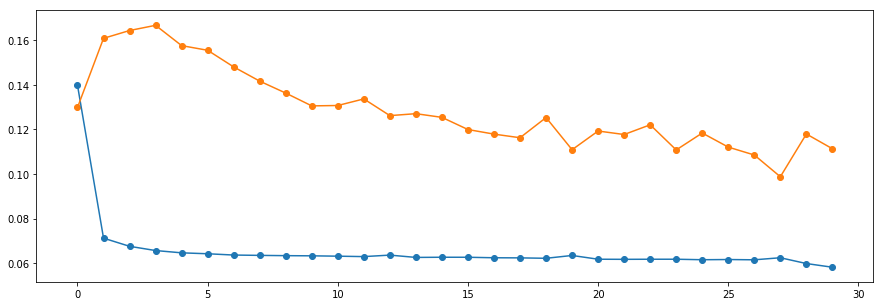

In [21]:
print(  history.history.keys()  )

plt.plot(range(len(history.history['loss'])), history.history['loss'])
plt.scatter(range(len(history.history['loss'])), history.history['loss'])
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
plt.scatter(range(len(history.history['val_loss'])), history.history['val_loss'])


In [99]:
pred = model.predict(X_test)
pred.shape

(3042, 2048, 1)

In [100]:
y_pred = np.exp(-pred[:,:,0]*10)
y_true = np.exp(-X_test[:,:,0]*10)

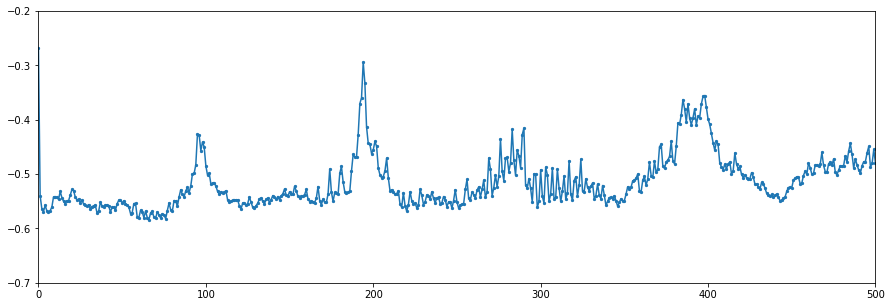

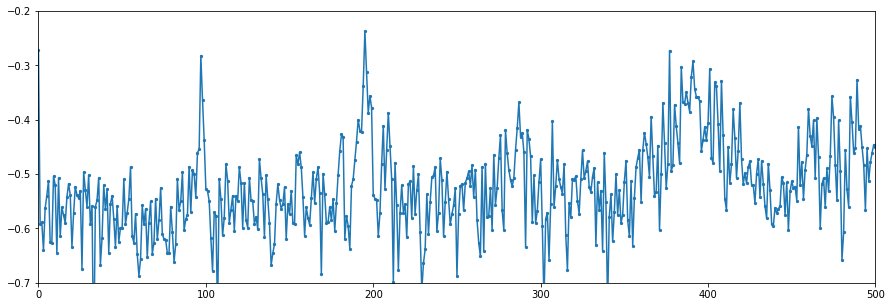

In [101]:
n_ = 0
plt.rcParams['figure.figsize'] = [15.0, 5.0]
plt.rcParams['font.size'] = 10
plt.xlim(0, 500)
plt.ylim(-0.7, -0.2)

plt.plot(range(2048), -pred[n_,:,0])
plt.scatter(range(2048), -pred[n_,:,0], s=5)
plt.show()

plt.xlim(0, 500)
plt.ylim(-0.7, -0.2)
plt.plot(range(2048), -X_test[n_,:,0])
plt.scatter(range(2048), -X_test[n_,:,0], s=5)
plt.show()

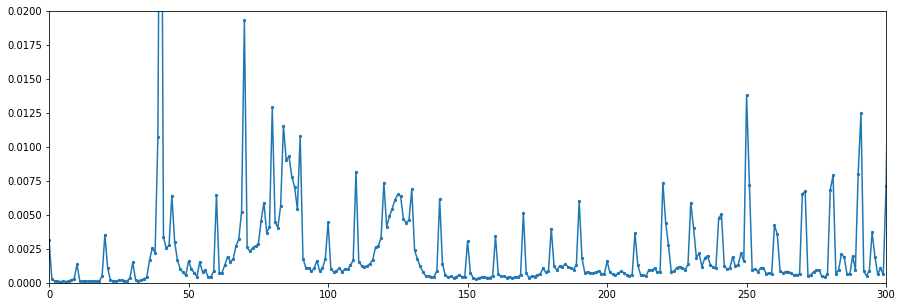

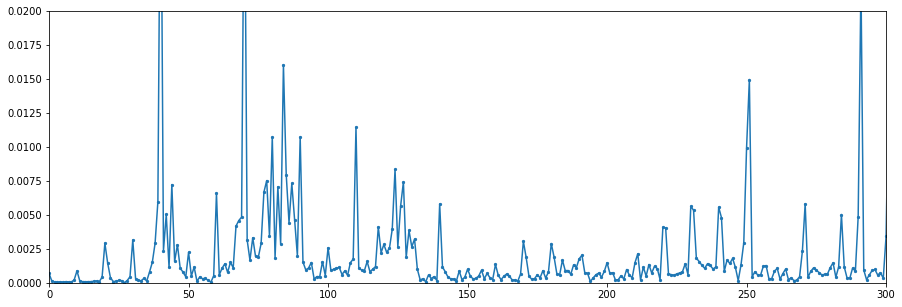

In [102]:
n_ = 42
plt.rcParams['figure.figsize'] = [15.0, 5.0]
plt.rcParams['font.size'] = 10
plt.xlim(0, 300)
plt.ylim(0, 0.02)
plt.plot(range(2048), y_pred[n_,:])
plt.scatter(range(2048), y_pred[n_,:], s=5)
plt.show()

plt.xlim(0, 300)
plt.ylim(0, 0.02)
plt.plot(range(2048), y_true[n_,:])
plt.scatter(range(2048), y_true[n_,:], s=5)
plt.show()

In [25]:
#model2.save('ft_extract_01.h5')
#model3 = models.load_model('ft_extract_01.h5')
#model3.summary()

In [26]:
x_embd = model2.predict(X_test).reshape((len(X_test), -1) )
print(  x_embd.shape  )

(3042, 4096)


In [27]:
#idx = np.random.randint(0,10000,1000)
#X_sample = x_embd[idx]
#Y_sample = y_test[idx]
X_sample = x_embd
#Y_sample = y_train

t1 = time.time()
#tsne = manifold.TSNE(n_components=2, init='pca', random_state=2, n_iter=1000)
tsne = manifold.TSNE(n_components=2, random_state=2, n_iter=250)
X_tsne = tsne.fit_transform(X_sample)
print(  time.time() - t1  )

32.727593421936035


In [28]:
Y_sample = y1_test[:,1]

In [29]:
def plot_embedding(X, title=None):     
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)                           

    plt.figure()              
    ax = plt.subplot(111)      
    for i in range(X.shape[0]):                          
        plt.text(X[i, 0], X[i, 1], str(Y_sample[i]),    
                 color= plt.cm.Set1(Y_sample[i]/4),         
                 fontdict={'weight': 'bold', 'size': 16})
        
    #plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)   

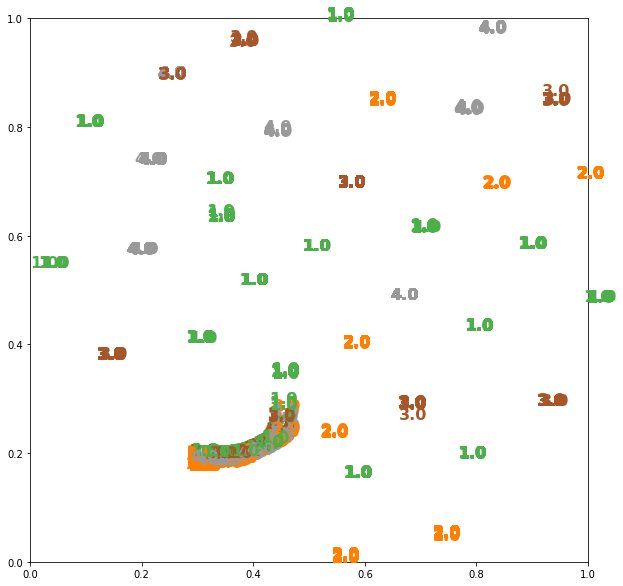

3.2454726696014404


In [30]:
t1 = time.time()

plt.rcParams['figure.figsize'] = [10.0, 10.0]
plt.rcParams['font.size'] = 10
#plot_embedding(X_tsne, "t-SNE embedding of the digits (time %.2fs)" %(time() - t0))                           
plot_embedding(X_tsne, )                           
plt.show()

print(  time.time() - t1  )

In [31]:
X_sample1 = X_test[:,:,0].copy()
t1 = time.time()
#tsne = manifold.TSNE(n_components=2, init='pca', random_state=2, n_iter=1000)
tsne = manifold.TSNE(n_components=2, random_state=2, n_iter=250)
X_tsne1 = tsne.fit_transform(X_sample1)
print(  time.time() - t1  )

31.016953468322754


In [32]:
Y_sample1 = y1_test[:,2]
def plot_embedding(X, title=None):     
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)                           

    plt.figure()              
    ax = plt.subplot(111)      
    for i in range(X.shape[0]):                          
        plt.text(X[i, 0], X[i, 1], str(Y_sample1[i]),    
                 color= plt.cm.Set1(Y_sample1[i]/2),         
                 fontdict={'weight': 'bold', 'size': 16})
        
    #plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)   

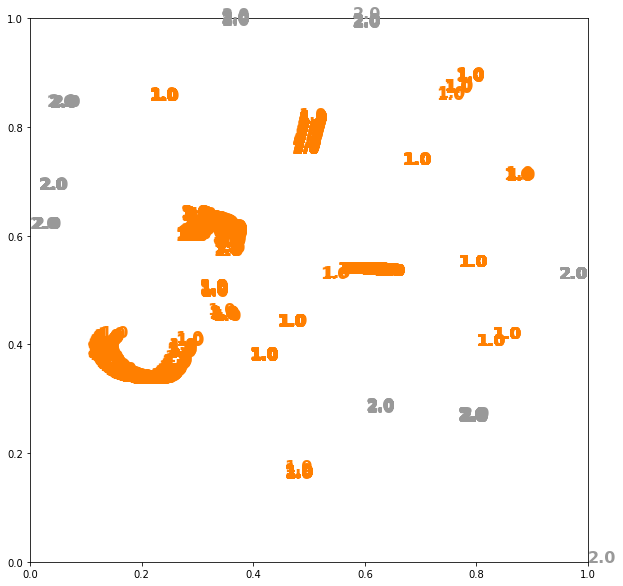

3.187091827392578


In [33]:
t1 = time.time()

plt.rcParams['figure.figsize'] = [10.0, 10.0]
plt.rcParams['font.size'] = 10
#plot_embedding(X_tsne, "t-SNE embedding of the digits (time %.2fs)" %(time() - t0))                           
plot_embedding(X_tsne1, )                           
plt.show()

print(  time.time() - t1  )

In [34]:
# expt 01

In [35]:
'''
codes for Yu-Ting (tested on Colab with only cpu):

%matplotlib inline
import os, time, shutil
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#from coslib import plot_polygon_seg_test_NG, plot_polygon_seg_test_OK
#from coslib import load_images_masks_json
#from coslib import get_mask_seg_polygon,  get_mask_seg_polygon_OK
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import datasets, manifold
#from scipy.ndimage import rotate
from IPython.display import Image
import random
import tensorflow as tf
random.seed(42)
np.random.seed(42)


from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D,Lambda, Conv2DTranspose, concatenate, BatchNormalization
from keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time
from keras.layers import Dropout

from keras import layers
from keras import models
import keras.backend as K


!ls

X_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

#model2.save('ft_extract_01.h5')
model2 = models.load_model('ft_extract_01.h5')
model2.summary()

input_data = X_test[:1]
x_embd = model2.predict(input_data).reshape((len(input_data), -1) )
print(  x_embd.shape  )




'''

"\ncodes for Yu-Ting (tested on Colab with only cpu):\n\n%matplotlib inline\nimport os, time, shutil\nimport numpy as np\nimport pandas as pd\nimport cv2\nimport matplotlib.pyplot as plt\n#import matplotlib.image as mpimg\n#from coslib import plot_polygon_seg_test_NG, plot_polygon_seg_test_OK\n#from coslib import load_images_masks_json\n#from coslib import get_mask_seg_polygon,  get_mask_seg_polygon_OK\n#from sklearn.model_selection import train_test_split\n#from sklearn.metrics import roc_curve,roc_auc_score\nfrom sklearn import datasets, manifold\n#from scipy.ndimage import rotate\nfrom IPython.display import Image\nimport random\nimport tensorflow as tf\nrandom.seed(42)\nnp.random.seed(42)\n\n\nfrom keras.models import Model\nfrom keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D,Lambda, Conv2DTranspose, concatenate, BatchNormalization\nfrom keras.optimizers import Adam\nfrom keras import optimizers\nfrom keras.callbacks import ModelCheckpoint, LearningRateSchedul

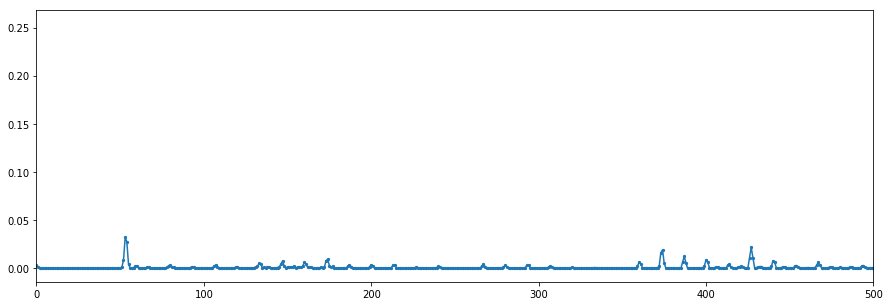

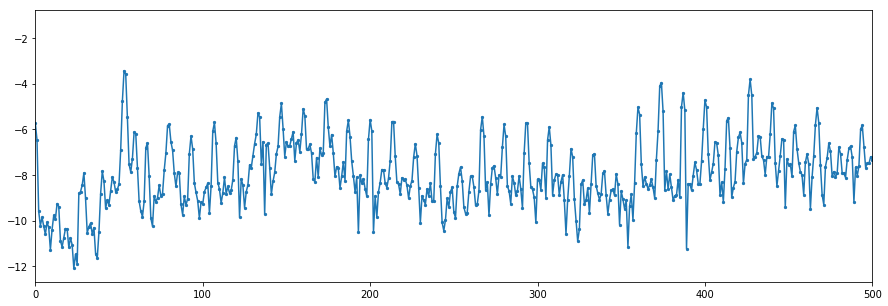

ValueError: x and y must have same first dimension, but have shapes (2049,) and (2048,)

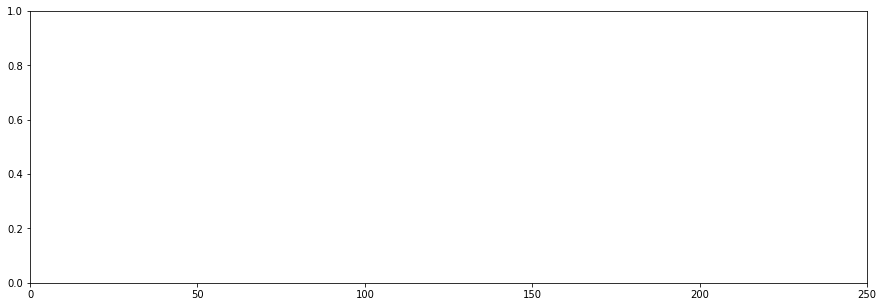

In [36]:

plt.rcParams['figure.figsize'] = [15.0, 5.0]
plt.rcParams['font.size'] = 10
plt.xlim(0, 500)
plt.plot(range(4097), data[j,:])
plt.scatter(range(4097), data[j,:], s=5)
plt.show()

plt.xlim(0, 500)
plt.plot(range(4097), data_log[j,:])
plt.scatter(range(4097), data_log[j,:], s=5)
plt.show()

plt.xlim(0, 250)
plt.plot(range(2049), data_down_log[j,:])
plt.scatter(range(2049), data_down_log[j,:], s=5)
plt.show()

plt.xlim(0, 250)
plt.plot(range(2049), data_norm[j,:])
plt.scatter(range(2049), data_norm[j,:], s=5)
plt.show()

In [37]:
plt.plot(range(len(history.history['conv1d_375_acc'])), history.history['conv1d_375_acc'])
plt.scatter(range(len(history.history['conv1d_375_acc'])), history.history['conv1d_375_acc'])
plt.plot(range(len(history.history['val_conv1d_375_acc'])), history.history['val_conv1d_375_acc'])
plt.scatter(range(len(history.history['val_conv1d_375_acc'])), history.history['val_conv1d_375_acc'])


KeyError: 'conv1d_375_acc'

In [ ]:
#from keras.utils.training_utils import multi_gpu_model
#model = multi_gpu_model(model, gpus=4)

#(model.layers[-1].get_weights())[0]

NameError: name 'preds_test' is not defined

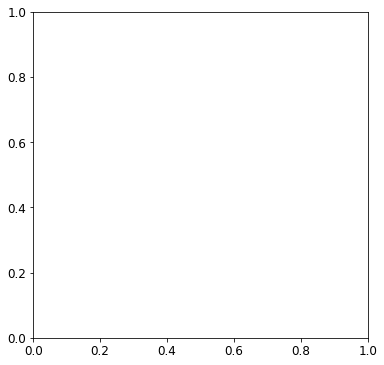

In [38]:
plt.rcParams['figure.figsize'] = [6.0, 6.0]
plt.rcParams['font.size'] = 12

for ii in range(1):    
    plt.subplot(1,1,ii+1)
    #pred_arr = aa[:,:,ii].reshape(-1,1)
    pred_arr = preds_test[:,0]
    #ans_arr = y1_test[:,:1270,ii].reshape(-1,1)
    ans_arr = preds_test[:,1]<7
    fpr , tpr , thresholds = roc_curve ( ans_arr , pred_arr) 
    #tpr = tpr+0.2*fpr*(1-fpr)

    plt.plot(fpr,tpr) 
    #plt.scatter(fpr,tpr) 
    plt.plot(range(len(tpr)),range(len(tpr)), color='black', linestyle='dashed') 
    plt.axis([-0.01,1.01,-0.01,1.01]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    #print(  roc_auc_score(ans_arr ,pred_arr)   )
    plt.legend(['ROC, AUC = %.3f '%(roc_auc_score(ans_arr ,pred_arr))])
plt.show()

In [40]:
y1 = np.zeros_like(y1_input)
y1[y1_input==1]=1 

#hot0 = np.zeros_like(y1_input)
hot1 = np.zeros_like(y1_input)
hot2 = np.zeros_like(y1_input)
hot3 = np.zeros_like(y1_input)

#hot0[y1_input==0] = 1
#hot1[y1_input==1] = 1
hot1[(y1_input==1)|(y1_input==0)] = 1
hot2[y1_input==2] = 1
hot3[y1_input==3] = 1

#y1=np.concatenate([hot0,hot1,hot2,hot3,hot4,hot5],axis=2)
#y1=np.concatenate([hot0,hot1,hot2,hot3,hot4,hot5,hot6],axis=2)
y1=np.concatenate([hot1,hot2,hot3,hot4,hot5,hot6],axis=2)

hot0_ = np.zeros_like(y2_input)
hot1_ = np.zeros_like(y2_input)
hot2_ = np.zeros_like(y2_input)

hot0_[y2_input==0] = 1
hot1_[y2_input==1] = 1
hot2_[y2_input==2] = 1

#y1=np.concatenate([hot0,hot1,hot2,hot3,hot4,hot5],axis=2)
y2=np.concatenate([hot0_,hot1_,hot2_],axis=2)

NameError: name 'y1_input' is not defined

In [89]:
def unet1D(nb_flt = 8, drop_rate = 0.1):
    kernel_size = 7
    
    inputs = Input((img_rows, 2))
    #inputs_norm = Lambda(lambda x: x/127.5 )
    #inputs_norm = Lambda(lambda x: x/1. )        
    #conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs_norm(inputs))
    conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs)

    conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2, )(conv1)
    
    conv2 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2,)(conv2)

    conv3 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size= 2,)(conv3)

    conv4 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling1D(pool_size=2)(conv4)

    conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool4)
    #conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv5)
    #conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv5)
    conv5 = Dropout(drop_rate)(conv5)
    
    up6 = concatenate([Conv1DTranspose(conv5, 8*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv4], axis=2)
    
    conv6 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up6)
    conv6 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv6)
    up7 = concatenate([Conv1DTranspose(conv6, 4*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv3], axis=2)
    
    ##up7 = concatenate([Conv2DTranspose(4*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv4), conv3], axis=3)
    
    conv7 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(up7)
    conv7 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv1DTranspose(conv7, 2*nb_flt, kernel_size= 2, strides= 2,
                                       padding='same'), conv2], axis=2)
    ##up8 = concatenate([Conv2DTranspose(2*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv3), conv2], axis=3)
    conv8 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(up8)
    conv8 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv1DTranspose(conv8, nb_flt, kernel_size=2, strides=2, padding='same'), conv1], axis=2)

    conv9 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(up9)
    conv9 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv9)
    ##conv9 = Dropout(drop_rate)(conv9)

    #conv10 = layers.Conv1D(1, 1, activation='sigmoid')(conv9)
    
    
    
    #conv10 = layers.Conv1D(7, 1, activation='softmax')(conv9)
    conv10 = layers.Conv1D(6, 1, activation='softmax')(conv9)
    conv11 = layers.Conv1D(3, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=[conv10,conv11]    )
    
    
    return model

In [86]:
def unet1D_21(nb_flt = 8, drop_rate = 0.1):
    kernel_size = 7
    
    inputs = Input((img_rows, 2))
    #inputs_norm = Lambda(lambda x: x/127.5 )
    #inputs_norm = Lambda(lambda x: x/1. )        
    #conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs_norm(inputs))
    conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2, )(conv1)
    
    conv2 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2,)(conv2)

    conv3 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2,)(conv3)

    conv4 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling1D(pool_size=2)(conv4)

    conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv5)
    pool5 = layers.MaxPooling1D(pool_size=2)(conv5)
    
    
    conv51 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool5)
    conv51 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv51)
    pool51 = layers.MaxPooling1D(pool_size=2)(conv51)
    
    conv52 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool51)
    conv52 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv52)
    pool52 = layers.MaxPooling1D(pool_size=2)(conv52)
    
    
    
    conv6_ = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool52)
    #conv6_ = Dropout(drop_rate)(conv6_)
#    conv6_ = layers.Conv1D(8*nb_flt,  kernel_size, activation='relu', padding='same')(conv6_)
#    conv6_ = Dropout(drop_rate)(conv6_)
    conv6_ = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv6_)
    conv6_ = Dropout(drop_rate)(conv6_)
    
    
    #conv6 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool5)
    #conv6 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv6)
    #conv6 = Dropout(drop_rate)(conv6)
    #conv6 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv6)
    #conv6 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv6)
    #conv6 = Dropout(drop_rate)(conv6)
    
    
    up72 = concatenate([Conv1DTranspose(conv6_, 16*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv52], axis=2)
    conv72 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up72)
    conv72 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv72)
    up71 = concatenate([Conv1DTranspose(conv72, 16*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv51], axis=2)
    
    conv71 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up71)
    conv71 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv71)
    up7 = concatenate([Conv1DTranspose(conv71, 16*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv5], axis=2)
    
    conv7 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up7)
    conv7 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv7)
    up8 = concatenate([Conv1DTranspose(conv7, 8*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv4], axis=2)
    
    conv8 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(up8)
    conv8 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv8)
    up9 = concatenate([Conv1DTranspose(conv8, 4*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv3], axis=2)
    
    ##up7 = concatenate([Conv2DTranspose(4*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv4), conv3], axis=3)
    
    conv9 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(up9)
    conv9 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv9)

    up10 = concatenate([Conv1DTranspose(conv9, 2*nb_flt, kernel_size= 2, strides= 2,
                                       padding='same'), conv2], axis=2)
    ##up8 = concatenate([Conv2DTranspose(2*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv3), conv2], axis=3)
    conv10 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(up10)
    conv10 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv10)

    up11 = concatenate([Conv1DTranspose(conv10, nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv1], axis=2)

    conv11 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(up11)
    conv11 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv11)

    
    conv12 = layers.Conv1D(6, 1, activation='softmax')(conv11)
    conv13 = layers.Conv1D(3, 1, activation='softmax')(conv11)

    model = Model(inputs=inputs, outputs=[conv12,conv13]    )

    
    return model

In [135]:
def unet1D_3(nb_flt = 8, drop_rate = 0.1):
    kernel_size = 7
    
    inputs = Input((img_rows, 2))
    #inputs_norm = Lambda(lambda x: x/127.5 )
    #inputs_norm = Lambda(lambda x: x/1. )        
    #conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs_norm(inputs))
    conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs)

    conv1 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2, )(conv1)
    
    conv2 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2,)(conv2)

    conv3 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling1D(pool_size= 2,)(conv3)

    conv4 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling1D(pool_size=2)(conv4)

    conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool4)
    #conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv5)
    #conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv5)
    conv5 = Dropout(drop_rate)(conv5)
    
    up6 = concatenate([Conv1DTranspose(conv5, 8*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv4], axis=2)
    
    conv6 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up6)
    conv6 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv6)
    up7 = concatenate([Conv1DTranspose(conv6, 4*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv3], axis=2)
    
    ##up7 = concatenate([Conv2DTranspose(4*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv4), conv3], axis=3)
    
    conv7 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(up7)
    conv7 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv1DTranspose(conv7, 2*nb_flt, kernel_size= 2, strides= 2,
                                       padding='same'), conv2], axis=2)
    ##up8 = concatenate([Conv2DTranspose(2*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv3), conv2], axis=3)
    conv8 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(up8)
    conv8 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv1DTranspose(conv8, nb_flt, kernel_size=2, strides=2, padding='same'), conv1], axis=2)

    conv9 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(up9)
    conv9 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv9)

    ################################################################################
    
    conv1_ = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(inputs)

    conv1_ = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv1_)
    pool1_ = layers.MaxPooling1D(pool_size=2, )(conv1_)
    
    conv2_ = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(pool1_)
    conv2_ = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv2_)
    pool2_ = layers.MaxPooling1D(pool_size=2,)(conv2_)

    conv3_ = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(pool2_)
    conv3_ = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv3_)
    pool3_ = layers.MaxPooling1D(pool_size= 2,)(conv3_)

    conv4_ = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool3_)
    conv4_ = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv4_)
    pool4_ = layers.MaxPooling1D(pool_size=2)(conv4_)

    conv5_ = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool4_)
    #conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool4)
    conv5_ = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv5_)
    #conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv5)
    conv5_ = Dropout(drop_rate)(conv5_)
    
    up6_ = concatenate([Conv1DTranspose(conv5_, 8*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv4_], axis=2)
    
    conv6_ = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up6_)
    conv6_ = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv6_)
    up7_ = concatenate([Conv1DTranspose(conv6_, 4*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv3_], axis=2)
    
    ##up7 = concatenate([Conv2DTranspose(4*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv4), conv3], axis=3)
    
    conv7_ = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(up7_)
    conv7_ = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv7_)

    up8_ = concatenate([Conv1DTranspose(conv7_, 2*nb_flt, kernel_size= 2, strides= 2,
                                       padding='same'), conv2_], axis=2)
    ##up8 = concatenate([Conv2DTranspose(2*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv3), conv2], axis=3)
    conv8_ = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(up8_)
    conv8_ = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv8_)

    up9_ = concatenate([Conv1DTranspose(conv8_, nb_flt, kernel_size=2, strides=2, padding='same'), conv1_], axis=2)

    conv9_ = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(up9_)
    conv9_ = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv9_)
    
    conv9c = concatenate([conv9, conv9_], axis=2)
    #conv9c = layers.Conv1D(2*nb_flt, 1, activation='relu', padding='same')(conv9c)                                                                                  
    conv9c = layers.Conv1D(nb_flt, 1, activation='relu', padding='same')(conv9c)                                                                                
    ###############################################################################
    
    conv11 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv9c)

    conv11 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv11)
    pool11 = layers.MaxPooling1D(pool_size=2, )(conv11)
    
    conv12 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(pool11)
    conv12 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv12)
    pool12 = layers.MaxPooling1D(pool_size=2,)(conv12)

    conv13 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(pool12)
    conv13 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv13)
    pool13 = layers.MaxPooling1D(pool_size= 2,)(conv13)

    conv14 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(pool13)
    conv14 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv14)
    pool14 = layers.MaxPooling1D(pool_size=2)(conv14)

    conv15 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool14)
    #conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(pool4)
    conv15 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv15)
    #conv5 = layers.Conv1D(16*nb_flt, kernel_size, activation='relu', padding='same')(conv5)
    conv15 = Dropout(drop_rate)(conv15)
    
    up16 = concatenate([Conv1DTranspose(conv15, 8*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv14], axis=2)
    
    conv16 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(up16)
    conv16 = layers.Conv1D(8*nb_flt, kernel_size, activation='relu', padding='same')(conv16)
    up17 = concatenate([Conv1DTranspose(conv16, 4*nb_flt, kernel_size=2, strides=2,
                                       padding='same'), conv13], axis=2)
    
    ##up7 = concatenate([Conv2DTranspose(4*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv4), conv3], axis=3)
    
    conv17 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(up17)
    conv17 = layers.Conv1D(4*nb_flt, kernel_size, activation='relu', padding='same')(conv17)

    up18 = concatenate([Conv1DTranspose(conv17, 2*nb_flt, kernel_size= 2, strides= 2,
                                       padding='same'), conv12], axis=2)
    ##up8 = concatenate([Conv2DTranspose(2*nb_flt, kernel_size=(2, 2), strides=(2, 2),
    ##                                   padding='same')(conv3), conv2], axis=3)
    conv18 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(up18)
    conv18 = layers.Conv1D(2*nb_flt, kernel_size, activation='relu', padding='same')(conv18)

    up19 = concatenate([Conv1DTranspose(conv18, nb_flt, kernel_size=2, strides=2,
                                        padding='same'), conv11], axis=2)

    conv19 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(up19)
    conv19 = layers.Conv1D(nb_flt, kernel_size, activation='relu', padding='same')(conv19)
    
        
    conv10 = layers.Conv1D(6, 1, activation='softmax')(conv9)
    conv11 = layers.Conv1D(3, 1, activation='softmax')(conv9_)
    conv20 = layers.Conv1D(6, 1, activation='softmax')(conv19)
    #conv21 = layers.Conv1D(3, 1, activation='softmax')(conv19)
    
    
    #model = Model(inputs=inputs, outputs=[conv10,conv11,conv20,conv21]    )
    model = Model(inputs=inputs, outputs=[conv10,conv11,conv20]    )

    
    return model

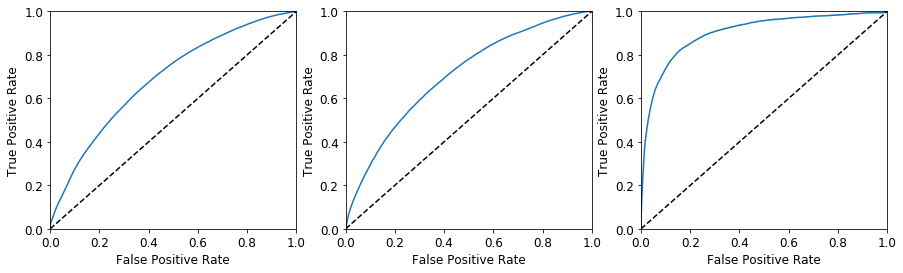

In [321]:
plt.rcParams['figure.figsize'] = [15, 4.0]
plt.rcParams['font.size'] = 12

for ii in range(3):    
    plt.subplot(1,3,ii+1)
    pred_arr = aa2[:,:,ii].reshape(-1,1)
    ans_arr = y2_test[:,:1216,ii].reshape(-1,1)
    fpr , tpr , thresholds = roc_curve ( ans_arr , pred_arr) 
    #pr = tpr+0.3*fpr*(1-fpr)
    plt.plot(fpr,tpr) 
    plt.plot(range(len(tpr)),range(len(tpr)), color='black', linestyle='dashed') 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
plt.show()